## Data Ingestion from the CSV file of the air quality dataset to InfluxDB on AWS EC2

In [141]:
import pandas as pd
import datetime as dt
from numpy import float64
import matplotlib.pyplot as plt
import seaborn as sns

# Import the new influxdb API client
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

# Read the csv into a dataframe
df = pd.read_csv("data/PRSA_Data_Dingling_20130301-20170228.csv")

In [142]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,3.0,NaN,200.0,82.0,-2.3,1020.8,-19.7,0.0,E,0.5,Dingling
1,2,2013,3,1,1,7.0,7.0,3.0,NaN,200.0,80.0,-2.5,1021.3,-19.0,0.0,ENE,0.7,Dingling
2,3,2013,3,1,2,5.0,5.0,3.0,2.0,200.0,79.0,-3.0,1021.3,-19.9,0.0,ENE,0.2,Dingling
3,4,2013,3,1,3,6.0,6.0,3.0,NaN,200.0,79.0,-3.6,1021.8,-19.1,0.0,NNE,1.0,Dingling
4,5,2013,3,1,4,5.0,5.0,3.0,NaN,200.0,81.0,-3.5,1022.3,-19.4,0.0,N,2.1,Dingling


<Figure size 720x432 with 0 Axes>

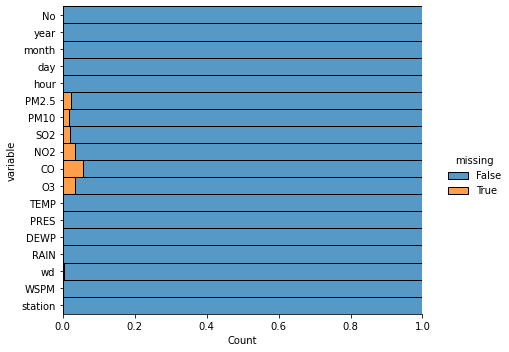

In [143]:
# Identify missing values
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
    )
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)


Text(0.5, 1.0, 'Quantifying missing data')

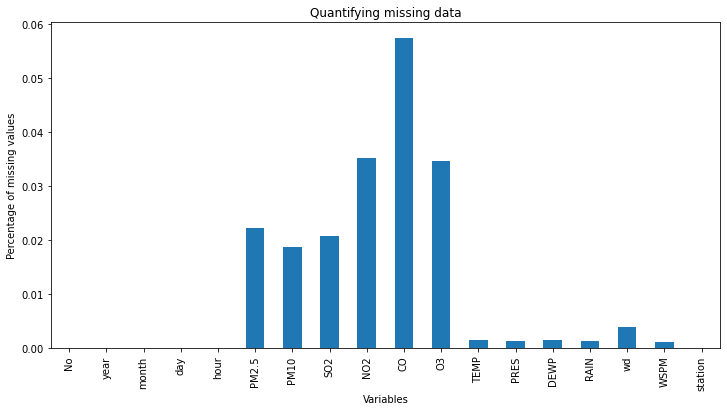

In [144]:
df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [145]:
df.dropna(axis=0, how='any', inplace=True)

Text(0.5, 1.0, 'Quantifying missing data')

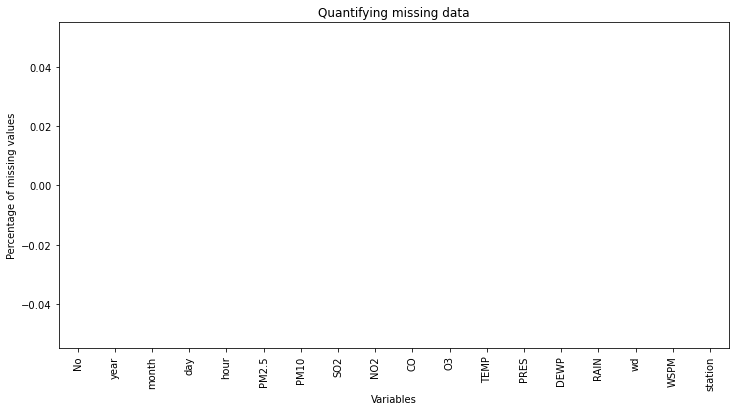

In [146]:
df.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

In [147]:
# As there is no timestamp on the dataset, only 4 separate column
# I am creating a timestamp out of the four columns
# needed for influx 2020-01-01T00:00:00.00Z
# lambda s : dt.datetime(*s) takes every row and convert them -> *s
# strftime to reformat the string into influxdb timestamp format
df['TimeStamp'] = df[['year', 'month', 'day', 'hour']].apply(
    lambda s: dt.datetime(*s).strftime('%Y-%m-%dT%H:%M:%SZ'), axis=1)

In [148]:
# setting the timestamp as the index of the dataframe
df.set_index('TimeStamp', inplace=True)

In [149]:
# dropping the year, month, day, hour, No from the dataframe
converted_ts = df.drop(['year', 'month', 'day', 'hour', 'No'], axis=1)

In [150]:
print(converted_ts)

                      PM2.5  PM10  SO2  NO2     CO     O3  TEMP    PRES  DEWP  \
TimeStamp                                                                       
2013-03-01T02:00:00Z    5.0   5.0  3.0  2.0  200.0   79.0  -3.0  1021.3 -19.9   
2013-03-01T05:00:00Z    6.0   6.0  3.0  4.0  200.0   79.0  -4.5  1022.6 -19.5   
2013-03-01T06:00:00Z    5.0  10.0  3.0  4.0  200.0   77.0  -4.5  1023.4 -19.5   
2013-03-01T07:00:00Z    5.0   6.0  3.0  2.0  200.0   80.0  -2.1  1024.6 -20.0   
2013-03-01T08:00:00Z    8.0   7.0  3.0  3.0  200.0   79.0  -0.2  1025.2 -20.5   
...                     ...   ...  ...  ...    ...    ...   ...     ...   ...   
2017-02-28T19:00:00Z   11.0  11.0  2.0  2.0  200.0   99.0  11.7  1008.9 -13.3   
2017-02-28T20:00:00Z   13.0  13.0  2.0  2.0  200.0  101.0  10.9  1009.0 -14.0   
2017-02-28T21:00:00Z    9.0  14.0  2.0  2.0  200.0  102.0   9.5  1009.4 -13.0   
2017-02-28T22:00:00Z   10.0  12.0  2.0  2.0  200.0   97.0   7.8  1009.6 -12.6   
2017-02-28T23:00:00Z   13.0 

In [151]:
# Changing the column types to float
ex_df = converted_ts.astype({"PM2.5": float64,
                             "PM10": float64,
                             "SO2": float64,
                             "NO2": float64,
                             "CO": float64,
                             "O3": float64,
                             "TEMP": float64,
                             "PRES": float64,
                             "DEWP": float64,
                             "RAIN": float64,
                             "WSPM": float64})

In [152]:
# Defining tag fields
datatags = ['station', 'wd']

In [153]:
#Setting up Database (Connection string)
client = influxdb_client.InfluxDBClient(
    url='http://ec2-3-120-10-156.eu-central-1.compute.amazonaws.com:8086',
    token='kp_gJV8Y7aOZB0odriHj1o_qWurQmxzBXpTU_kYY4JnQ88e9X1TI3ifFVA1pUyGZshZfTpeaTlTWgYAUESTMvw==',
    org='my-org'
)

In [154]:
# Writing the data with two tags
write_api = client.write_api(write_options=SYNCHRONOUS)
message = write_api.write(bucket='air-quality', org='my-org', record=ex_df,
data_frame_measurement_name='full-tags', data_frame_tag_columns=['station', 'wd'])
print(message)

None


In [155]:
# The asynchronous buffering API to Write time-series data into InfluxDB.
# This API always buffers points/lines to create batches under the hood to optimize data 
# transfer to InfluxDB server, flush is used to send the buffered data to InfluxDB immediately.
# I use flush() after each write as I was getting a "time out error message"
write_api.flush()

In [156]:
# Writing the data only with one tag
write_api = client.write_api(write_options=SYNCHRONOUS)
message = write_api.write(bucket='air-quality', org='my-org', record=ex_df,
data_frame_measurement_name='location-tag-only', data_frame_tag_columns=['station'])
print('Errors detected writing data to InfluxDB: ', message)

Errors detected writing data to InfluxDB:  None


In [157]:
write_api.flush()